In [1]:
%reload_ext autoreload
%autoreload 2

In [9]:
import sys  
sys.path.insert(0, '../../Code')

import numpy as np
import os
import pandas as pd
import statistics
import train_and_predict
import util
import matplotlib.pyplot as plt
import taxa

from matplotlib.font_manager import FontProperties
from Bio import SeqIO
from data import *
from visualization import *
from sklearn.metrics import classification_report

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [4]:
LABEL = 'Label'

WSPC = 'WSPC'
BACPACS = 'BacPaCS'
PATHOGEN_FINDER = 'PathogenFinder'
PAPRBAG = 'PaPrBaG'
DEEPAC = 'DeepaC'
DEEPAC_S = 'DeepaC S-LSTM'
DEEPAC_R = 'DeepaC R-CNN'

SEN = 'Sensitivity'
SPE = 'Specificity'
BACC = 'BACC'

TARGET_NAMES = ['NHP', 'HP']

In [5]:
def report_to_metrics(report):
    
    specificity = round(report['NHP']['recall'], 2)
    sensitivity = round(report['HP']['recall'], 2)
    bacc = round(report['macro avg']['recall'], 2)

    
    return {SPE: specificity, SEN: sensitivity, BACC: bacc}

# Load Bacpacs Dataset

In [10]:
bacpacs_dir_path = r'..\..\..\Data\Bacpacs\\'

bacpacs_genomes_path = bacpacs_dir_path + 'bacpacs_genomes.fasta'
bacpacs_metadata_path = bacpacs_dir_path + 'bacpacs_test.csv'

In [11]:
bacpacs_dataset = GenomesData(bacpacs_genomes_path, bacpacs_metadata_path)

In [12]:
len(bacpacs_dataset)

94

In [13]:
bacpacs_dataset.y.value_counts()

1    78
0    16
Name: Label, dtype: int64

## Balanced dataset (one genome per species)

In [14]:
balanced_dataset_genomes = bacpacs_dataset.metadata[bacpacs_dataset.metadata['Balanced Test'] == 'Yes'].index

In [15]:
bacpacs_data_balanced = bacpacs_dataset.data[balanced_dataset_genomes]

In [16]:
len(bacpacs_data_balanced)

40

In [17]:
bacpacs_dataset.y[balanced_dataset_genomes].value_counts()

1    25
0    15
Name: Label, dtype: int64

In [18]:
len(taxa.get_genomes_tax(bacpacs_data_balanced.index, taxa.GENUS))

30

# Analyzing Paprbag, pathogenfinder and bacpacs results from bacpacs supplemantry

In [19]:
paprbag_folds =  ['paprbag_fold1', 'paprbag_fold2', 'paprbag_fold3', 'paprbag_fold4', 'paprbag_fold5']
bacpacs_methods = ['bacpacs', 'pathogenfinder'] + paprbag_folds

In [20]:
bacpacs_comp_analysis_sup = pd.read_csv(bacpacs_dir_path + 'Bacpacs-Supplementary.csv', dtype=str).set_index('Genome ID')
bacpacs_comp_analysis_sup = bacpacs_comp_analysis_sup.replace(['hp'], 1)
bacpacs_comp_analysis_sup = bacpacs_comp_analysis_sup.replace(['nhp'], 0)

In [21]:
bacpacs_comp_analysis_sup.head()

,pathogenicity,bacpacs,pathogenfinder,paprbag_fold1,paprbag_fold2,paprbag_fold3,paprbag_fold4,paprbag_fold5,Genome Name,Organism Name,Isolation Source,Habitat,Disease,Host Health,Other Clinical,Comments
Genome ID,,,,,,,,,,,,,,,,
1041522.28,1,1,1,1,1,1,1,1,Mycobacterium colombiense CECT 3035 strain CECT 3035,NaN,blood,NaN,NaN,HIV,NaN,"M. colombiense infections were initially described in HIV patients in Bogot�, Colombia. In this initial study, M. colombiense was confirmed to be the causative agent of pulmonary disease and bacteraemia in this group of people who died of HIV/M. colombiense coinfection. After this study, M. colombiense has been isolated in other scenarios such as lymphadenopathy, subcutaneous infections and disseminated disease in HIV-negative patients in countries like Spain, France, China, Canada and Russia."
1196162.3,1,1,1,1,1,1,1,1,Listeria monocytogenes serotype 4b str. 10-0809 strain 10-0809,NaN,Stool,NaN,NaN,Listeriosis,NaN,Whole genome sequencing and comparison of Listeria monocytogenes Canadian food outbreaks
1196172.3,1,0,1,1,1,1,1,1,Listeria monocytogenes serotype 4b str. 02-1289 strain 02-1289,NaN,Stool,NaN,NaN,Listeriosis,NaN,Whole genome sequencing and comparison of Listeria monocytogenes Canadian food outbreaks
1280.11681,1,1,1,1,1,1,1,1,Staphylococcus aureus strain USA300-SUR15,NaN,Nose,NaN,NaN,NaN,NaN,The study characterizes a Staphylococcus aureus outbreak which took place in Paramaribo in the Republic of Suriname.
1280.12234,1,1,1,1,1,1,1,1,Staphylococcus aureus strain JE2,NaN,skin and soft tissue,NaN,NaN,Soft Tissue Infections,NaN,Sequence the genome of Staphylococcus aureus JE2


In [22]:
all_methods_preds = bacpacs_comp_analysis_sup.loc[bacpacs_dataset.y.index, bacpacs_methods]
all_methods_preds.loc[bacpacs_dataset.y.index, LABEL] = bacpacs_dataset.y

all_methods_preds.rename(columns={'bacpacs': BACPACS, 'pathogenfinder': PATHOGEN_FINDER}, inplace=True)

# deepac model

files can be downloaded from: https://drive.google.com/drive/folders/1Qa6Czj_igTqI48vLMt2mzRz9aYZYy6wo?usp=sharing

In [31]:
deepac_on_bacpacs_dir_path = r'..\..\..\Data\Bacpacs\deepac_on_bacpacsTest\\'

In [24]:
# create  dictionary: key - genome name, value - dictionary(key:frag name, val: prediction)
def create_all_preds_per_genome(seqFile):
    
    all_p_per_genome_patho_test = {}
    for fasta in seqFile:
        name_and_p = fasta.description
        genome_name = name_and_p.split('pathogenic/')[1].split('.fq')[0]
        frag =  name_and_p.split('.fq.')[1].split(' | ')[0]
        all_p_per_genome_patho_test.setdefault(genome_name, {})
        all_p_per_genome_patho_test[genome_name][frag] = float(name_and_p.split('pp=')[1]) 

    print(f'results len: {len(all_p_per_genome_patho_test)}')          
    return all_p_per_genome_patho_test

In [25]:

"""
 "One of the major challenges of pathogenic potential prediction from single
reads is the lack of biological context. However, if all the reads in a sample
originate from the exactly same organism, we can predict the pathogenic
potential of that organism by a ---majority vote---. In the context of probabilistic
estimates of the class label (returned by both PaPrBaG and our neural
networks), we can implement that as a ---simple mean over predictions for
all the individual reads---. 
Building upon this idea, we can boost read-based performance if
we consider ***read pairs***, assumed to originate from the same organism
even in metagenomic samples. To this end, ---we average predictions for
the corresponding pairs in our test set---. The classifiers may still predict
pathogenic potentials for isolated sequences if so desired."
"""

def calculate_final_genomes_predictions(test_preds_1, test_preds_2):
    
    all_p_per_genome_test1 = create_all_preds_per_genome(test_preds_1)
    all_p_per_genome_test2 = create_all_preds_per_genome(test_preds_2)
    genomes_predictions = {}
    for genome in all_p_per_genome_test1.keys():
        all_frags1 = all_p_per_genome_test1[genome]
        all_frags2 = all_p_per_genome_test2[genome]
        if len((set(all_frags1) - set(all_frags2))) > 0:
            print('Error')
            return
        all_preds = []
        for frag_id in all_frags1.keys():
            y_pred_1 = all_frags1[frag_id]
            y_pred_2 = all_frags2[frag_id]
            y_pred = (y_pred_1 + y_pred_2)/2
            all_preds.append(y_pred)
            
        final_pred = statistics.mean(all_preds)
        genomes_predictions[genome] = final_pred
    
    return genomes_predictions

In [26]:
def get_deepac_predictions(test_genomes, test_labels, patho_genomes_predictions, nonpatho_genomes_predictions, model):
    
    deepac_preds_df = pd.DataFrame(index=test_genomes, columns=['Label', model, 'Pred'])
    
    for genome_id in test_genomes:
        deepac_preds_df.at[genome_id, 'Label'] = int(test_labels.at[genome_id])
        if genome_id in patho_genomes_predictions.keys():
            pred = patho_genomes_predictions[genome_id]
            deepac_preds_df.at[genome_id, 'Pred'] = pred
            deepac_preds_df.at[genome_id, model] = 1 if pred > 0.5 else 0
            continue
        elif genome_id in nonpatho_genomes_predictions.keys():
            pred = nonpatho_genomes_predictions[genome_id]
            deepac_preds_df.at[genome_id, 'Pred'] = pred
            deepac_preds_df.at[genome_id, model] = 1 if pred > 0.5 else 0
            continue
        print(f'problem with genome: {genome_id}')
        
    deepac_preds_df[model] = pd.to_numeric(deepac_preds_df[model])

    return deepac_preds_df

In [27]:
def calc_pred_for_file_pairs(readpair_path1, readpair_path2):
    
    with open(readpair_path1) as f1, open(readpair_path2) as f2:
        test_1_preds = SeqIO.parse(f1,'fasta')
        test_2_preds = SeqIO.parse(f2,'fasta')
        
        return calculate_final_genomes_predictions(test_1_preds, test_2_preds)
    
    return None

In [28]:
def predict_deepac(dir_path, patho_path1, patho_path2, nonpatho_path1, nonpatho_path2, bacpacs_dataset, model):
    
    patho_genomes_predictions = calc_pred_for_file_pairs(dir_path+patho_path1, dir_path+patho_path2)
    non_patho_genomes_predictions = calc_pred_for_file_pairs(dir_path+nonpatho_path1, dir_path+nonpatho_path2)

    deepac_preds_df = get_deepac_predictions(bacpacs_dataset.metadata.index, bacpacs_dataset.y,
                                            patho_genomes_predictions, non_patho_genomes_predictions, model)
    
    return deepac_preds_df

## deepac s

In [32]:
lstm_patho_read_pair1 = 'patho_bacpacs_test1_withp_s.fasta'
lstm_patho_read_pair2 = 'patho_bacpacs_test2_withp_s.fasta'

lstm_nonpatho_read_pair1 = 'nonpatho_bacpacs_test1_withp_s.fasta'
lstm_nonpatho_read_pair2 = 'nonpatho_bacpacs_test2_withp_s.fasta'

deepac_s_preds_df = predict_deepac(deepac_on_bacpacs_dir_path, lstm_patho_read_pair1, 
                                   lstm_patho_read_pair2, lstm_nonpatho_read_pair1, 
                                   lstm_nonpatho_read_pair2, bacpacs_dataset, model=DEEPAC_S)

results len: 60
results len: 60
results len: 40
results len: 40


In [33]:
deepac_s_preds_df

,Label,DeepaC S-LSTM,Pred
Genome ID,,,
470.3353,1,1,0.902552
106654.48,1,1,0.905282
520.659,1,1,0.944372
28450.385,1,1,0.969431
83554.74,1,1,0.8229
813.141,1,1,0.814653
545.38,1,1,0.921595
777.186,1,1,0.835886
1352.1760,1,1,0.721741


In [34]:
pd.to_numeric(deepac_s_preds_df['Pred']).describe()

count    94.000000
mean      0.839597
std       0.165623
min       0.215412
25%       0.816715
50%       0.906335
75%       0.944143
max       0.969431
Name: Pred, dtype: float64

In [35]:
all_methods_preds.loc[deepac_s_preds_df.index, DEEPAC_S] = deepac_s_preds_df[DEEPAC_S]

# DEEPAC R

In [36]:
rcnn_patho_read_pair1 = 'patho_bacpacs_test1_withp.fasta'
rcnn_patho_read_pair2 = 'patho_bacpacs_test2_withp.fasta'

rcnn_nonpatho_read_pair1 = 'nonpatho_bacpacs_test1_withp.fasta'
rcnn_nonpatho_read_pair2 = 'nonpatho_bacpacs_test2_withp.fasta'

deepac_r_preds_df = predict_deepac(deepac_on_bacpacs_dir_path, rcnn_patho_read_pair1, 
                                   rcnn_patho_read_pair2, rcnn_nonpatho_read_pair1, 
                                   rcnn_nonpatho_read_pair2, bacpacs_dataset, model=DEEPAC_R)

results len: 60
results len: 60
results len: 40
results len: 40


In [37]:
deepac_r_preds_df.join(deepac_s_preds_df[[DEEPAC_S, 'Pred']], lsuffix='_R', rsuffix='_S')

,Label,DeepaC R-CNN,Pred_R,DeepaC S-LSTM,Pred_S
Genome ID,,,,,
470.3353,1,1,0.623975,1,0.902552
106654.48,1,1,0.62479,1,0.905282
520.659,1,1,0.731252,1,0.944372
28450.385,1,1,0.834428,1,0.969431
83554.74,1,1,0.585589,1,0.8229
813.141,1,1,0.592584,1,0.814653
545.38,1,1,0.74281,1,0.921595
777.186,1,1,0.591388,1,0.835886
1352.1760,1,1,0.516518,1,0.721741


In [38]:
pd.to_numeric(deepac_r_preds_df['Pred']).describe()

count    94.000000
mean      0.647606
std       0.100163
min       0.313134
25%       0.568120
50%       0.625869
75%       0.731660
max       0.835089
Name: Pred, dtype: float64

In [39]:
all_methods_preds.loc[deepac_r_preds_df.index, DEEPAC_R] = deepac_r_preds_df[DEEPAC_R]

## deepac validation

In [40]:
def extract_preds_from_reads(path):
    
    pred_arr = []

    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                pred_arr.append(float(line.strip().split('pp=')[-1]))

    return np.array(pred_arr)

In [41]:
def validate_deepac_preds(dir_path, reads_pred_file_pairs):
    
    for reads_file, npy_file in reads_pred_file_pairs:
        
        deepac_pred_arr1 = extract_preds_from_reads(dir_path + reads_file)
        deepac_pred_arr2 = np.load(dir_path + npy_file)
                
        is_close = np.isclose(deepac_pred_arr1, deepac_pred_arr2, atol=0.001)
        assert all(is_close)

In [42]:
lstm_patho_read_pair1_npy = 'patho_bacpacs_test_1_lstm_predictions.npy'
lstm_patho_read_pair2_npy = 'patho_bacpacs_test_2_lstm_predictions.npy'

lstm_nonpatho_read_pair1_npy = 'nonpatho_bacpacs_test_1_lstm_predictions.npy'
lstm_nonpatho_read_pair2_npy = 'nonpatho_bacpacs_test_2_lstm_predictions.npy'

rcnn_patho_read_pair1_npy = 'patho_bacpacs_test_1_rcnn_predictions.npy'
rcnn_patho_read_pair2_npy = 'patho_bacpacs_test_2_rcnn_predictions.npy'

rcnn_nonpatho_read_pair1_npy = 'nonpatho_bacpacs_test_1_rcnn_predictions.npy'
rcnn_nonpatho_read_pair2_npy = 'nonpatho_bacpacs_test_2_rcnn_predictions.npy'

In [43]:
reads_pred_file_pairs = [(lstm_patho_read_pair1, lstm_patho_read_pair1_npy),
                       (lstm_patho_read_pair2, lstm_patho_read_pair2_npy),
                       (lstm_nonpatho_read_pair1, lstm_nonpatho_read_pair1_npy),
                       (lstm_nonpatho_read_pair2, lstm_nonpatho_read_pair2_npy),
                       (rcnn_patho_read_pair1, rcnn_patho_read_pair1_npy),
                       (rcnn_patho_read_pair2, rcnn_patho_read_pair2_npy),
                       (rcnn_nonpatho_read_pair1, rcnn_nonpatho_read_pair1_npy),
                       (rcnn_nonpatho_read_pair2, rcnn_nonpatho_read_pair2_npy)]

In [44]:
validate_deepac_preds(deepac_on_bacpacs_dir_path, reads_pred_file_pairs)

# WSPC model

In [48]:
model_path = '..\..\WSPC Model\WSPC_model.pkl'

WSPC_cls = util.load_model(model_path)

In [49]:
preds = WSPC_cls.predict(bacpacs_dataset.data) 
all_methods_preds.loc[bacpacs_dataset.y.index, WSPC] = preds

In [50]:
all_methods_preds

,BacPaCS,PathogenFinder,paprbag_fold1,paprbag_fold2,paprbag_fold3,paprbag_fold4,paprbag_fold5,Label,DeepaC S-LSTM,DeepaC R-CNN,WSPC
Genome ID,,,,,,,,,,,
470.3353,1,1,1,1,1,1,1,1,1,1,1
106654.48,1,1,1,1,1,1,1,1,1,1,1
520.659,1,0,1,1,1,1,1,1,1,1,1
28450.385,1,1,1,1,1,1,1,1,1,1,1
83554.74,1,1,1,1,1,1,1,1,1,1,1
813.141,1,1,1,1,1,1,1,1,1,1,1
545.38,0,1,1,1,1,1,1,1,1,1,1
777.186,1,1,1,1,1,1,1,1,1,1,1
1352.1760,1,1,1,1,1,1,1,1,1,1,1


### Compute results for all classifiers

In [51]:
def get_cls_results(genomes, all_methods_preds, methods, measures):
    
    results = {}

    for method in methods:
        preds = all_methods_preds.loc[genomes, method]
        labels = all_methods_preds.loc[genomes, LABEL]
        report = classification_report(labels, preds, target_names=TARGET_NAMES, output_dict=True)
        method_results = report_to_metrics(report) 
        results[method] = method_results

    results[PAPRBAG] = {}
    for measure in measures:
        results[PAPRBAG][measure] = round(np.mean([results[fold][measure] for fold in paprbag_folds]), 2)

    return results

In [52]:
measures = [BACC, SEN, SPE]
methods = [WSPC, BACPACS, PATHOGEN_FINDER, DEEPAC_R, DEEPAC_S] + paprbag_folds
genomes = bacpacs_dataset.y.index

results_entire_test = get_cls_results(genomes, all_methods_preds, methods, measures)
results_entire_test[DEEPAC] = results_entire_test[DEEPAC_R]

results_entire_test

{'WSPC': {'Specificity': 0.88, 'Sensitivity': 0.99, 'BACC': 0.93},
 'BacPaCS': {'Specificity': 0.75, 'Sensitivity': 0.92, 'BACC': 0.84},
 'PathogenFinder': {'Specificity': 0.69, 'Sensitivity': 0.72, 'BACC': 0.7},
 'DeepaC R-CNN': {'Specificity': 0.31, 'Sensitivity': 0.99, 'BACC': 0.65},
 'DeepaC S-LSTM': {'Specificity': 0.31, 'Sensitivity': 0.99, 'BACC': 0.65},
 'paprbag_fold1': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BACC': 0.59},
 'paprbag_fold2': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BACC': 0.59},
 'paprbag_fold3': {'Specificity': 0.12, 'Sensitivity': 1.0, 'BACC': 0.56},
 'paprbag_fold4': {'Specificity': 0.19, 'Sensitivity': 0.99, 'BACC': 0.59},
 'paprbag_fold5': {'Specificity': 0.12, 'Sensitivity': 1.0, 'BACC': 0.56},
 'PaPrBaG': {'BACC': 0.58, 'Sensitivity': 0.99, 'Specificity': 0.16},
 'DeepaC': {'Specificity': 0.31, 'Sensitivity': 0.99, 'BACC': 0.65}}

In [53]:
results_balanced_test = get_cls_results(balanced_dataset_genomes, all_methods_preds, methods, measures)
results_balanced_test[DEEPAC] = results_balanced_test[DEEPAC_R]

results_balanced_test

{'WSPC': {'Specificity': 0.87, 'Sensitivity': 1.0, 'BACC': 0.93},
 'BacPaCS': {'Specificity': 0.73, 'Sensitivity': 0.84, 'BACC': 0.79},
 'PathogenFinder': {'Specificity': 0.67, 'Sensitivity': 0.96, 'BACC': 0.81},
 'DeepaC R-CNN': {'Specificity': 0.33, 'Sensitivity': 1.0, 'BACC': 0.67},
 'DeepaC S-LSTM': {'Specificity': 0.33, 'Sensitivity': 1.0, 'BACC': 0.67},
 'paprbag_fold1': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BACC': 0.6},
 'paprbag_fold2': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BACC': 0.6},
 'paprbag_fold3': {'Specificity': 0.13, 'Sensitivity': 1.0, 'BACC': 0.57},
 'paprbag_fold4': {'Specificity': 0.2, 'Sensitivity': 1.0, 'BACC': 0.6},
 'paprbag_fold5': {'Specificity': 0.13, 'Sensitivity': 1.0, 'BACC': 0.57},
 'PaPrBaG': {'BACC': 0.59, 'Sensitivity': 1.0, 'Specificity': 0.17},
 'DeepaC': {'Specificity': 0.33, 'Sensitivity': 1.0, 'BACC': 0.67}}

# Plots

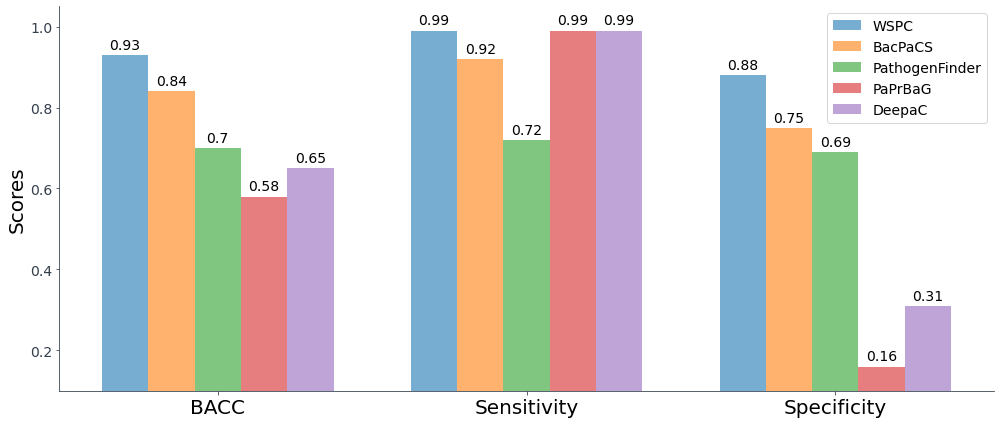

In [54]:
out_path = '..\..\Paper\Figures\\'
fig_name = 'Comparative_benchmark1_bacpacs.pdf'
methods = [WSPC, BACPACS, PATHOGEN_FINDER, PAPRBAG, DEEPAC]
measures = [BACC, SEN, SPE]

create_grouped_barplots(results_entire_test, bar_groups=measures, bars=methods, out_path=out_path+fig_name)

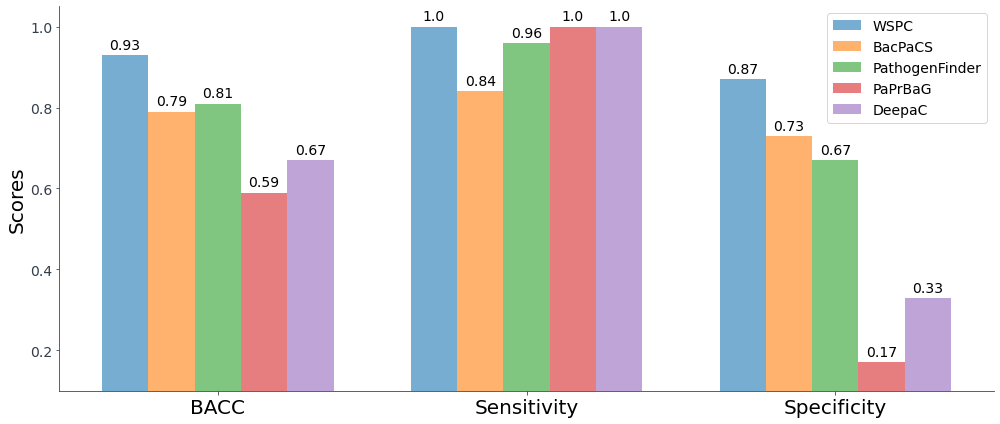

In [55]:
fig_name = 'Comparative_benchmark2_bacpacs_balanced.pdf'

create_grouped_barplots(results_balanced_test, bar_groups=measures, bars=methods, out_path=out_path+fig_name)